In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Input,Dense,Conv2DTranspose

In [2]:
class TfConv2D(tf.Module):
    def __init__(self, kernel=(3, 3), channels=1, strides=(2, 2), padding='SAME', activate="relu"):
        super().__init__()
        self.kernel = kernel
        self.channels = channels
        self.strides = strides
        self.padding = padding
        self.activate = activate
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((*self.kernel, x.shape[-1], self.channels),dtype = tf.double ,stddev=0.1)
            self.b = tf.zeros([self.channels], dtype=tf.double)
            print(self.w)

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)

            self.fl_init = True

        y = tf.nn.conv2d(x, self.w, strides=(1, *self.strides, 1), padding=self.padding)

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)

        return y


In [3]:
## Autoencoder

In [6]:
enc_input = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu')(enc_input)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Flatten()(x)
enc_output = Dense(8, activation='linear')(x)

enc_model = keras.Model(enc_input, enc_output, name="encoder")
#enc_model.summary()

In [7]:
dec_input = tf.keras.Input(shape = (8,))
x = tf.keras.layers.Dense(7*7*8)(dec_input)
x = tf.keras.layers.Reshape((7,7,8))(x)
x = tf.keras.layers.Conv2DTranspose(64,5,strides =(2,2),padding = 'same' )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Conv2DTranspose(32,5,(2,2),padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
dec_output = Conv2DTranspose(1,3,padding = 'same')(x)

dec_model = tf.keras.Model(dec_input,dec_output)
#dec_model.summary()

In [8]:
aec_input = tf.keras.Input((28,28,1))
x= enc_model(aec_input)
aec_output = dec_model(x)
aec = keras.Model(aec_input,aec_output)


In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [10]:
aec.compile(optimizer='adam', loss='mean_squared_error')
aec.fit(x_train,x_train,batch_size = 32, epochs = 1)

1875/1875 [==============================] - 34s 8ms/step - loss: 0.0453


1/1 [==============================] - 0s 75ms/step


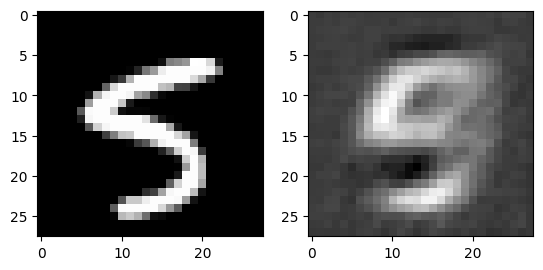

In [17]:
img = aec.predict(tf.expand_dims(x_test[1221],axis = 0))
plt.subplot(121)
plt.imshow(x_test[1221],cmap = 'gray')
plt.subplot(122)
plt.imshow(img.squeeze(),cmap = 'gray')